# Step Forward Cross Validation for Bioactivity Prediction

## Generate Table and Plots for Distribution of Sorting properties per Split type per fold across targets

In [1]:
import os
from sfcv import SortedStepForwardCV, UnsortedStepForwardCV, ScaffoldSplitCV, RandomSplitCV

In [2]:
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
cv_splitters = {
    "RandomSplit": RandomSplitCV(frac_train=0.9, n_folds=10, seed=69420),
    "ScaffoldSplit": ScaffoldSplitCV(smiles_col='standardized_smiles', n_folds=10, frac_train=0.9, seed=69420,
                                     include_chirality=False),
    "SortedStepForward_LogD": SortedStepForwardCV(sorting_col="LogD", ideal=2, n_bins=10, ascending=False),
    "SortedStepForward_LogP": SortedStepForwardCV(sorting_col="LogP", ideal=2, n_bins=10, ascending=False),
    "SortedStepForward_MCE18": SortedStepForwardCV(sorting_col="MCE18", n_bins=10, ascending=True),
    "UnsortedStepForward": UnsortedStepForwardCV(n_bins=10, random_state=69420)
}

In [4]:
def add_cv_split_columns(df, cv_splitters):
    df = df.copy()

    # Iterate over each split type
    for split_name, cv_splitter in cv_splitters.items():
        # Iterate over folds
        for fold_idx, (train_idx, test_idx) in enumerate(cv_splitter.split(df), start=1):
            col_name = f"{split_name}_Fold_{fold_idx}"  # Create column name

            # Initialize all entries as "None"
            df[col_name] = None

            # Assign "Train" and "Test" labels
            df.loc[train_idx, col_name] = "Train"
            df.loc[test_idx, col_name] = "Test"

    return df

In [5]:
ddf = {}

for fname in tqdm(os.listdir('../benchmark/data/processed/'), desc="Processing Splits"):
    if fname.endswith('.csv'):
        df = pd.read_csv(f"../benchmark/data/processed/{fname}")
        ddf[fname[:-4]] = add_cv_split_columns(df, cv_splitters)

/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)
/Users/manasmahale/projects/sfcv/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return b

In [6]:
split_types = [
    "RandomSplit",
    "ScaffoldSplit",
    "SortedStepForward_LogD",
    "SortedStepForward_LogP",
    "SortedStepForward_MCE18",
    "UnsortedStepForward"
]
metrics = ["LogP", "LogD", "MCE18"]

In [7]:
plot_data = []

for dataset_name, df in ddf.items():
    for split in split_types:
        for fold in range(1, 10):  # Folds 1 to 9
            split_column = f"{split}_Fold_{fold}"
            if split_column in df.columns:
                for metric in metrics:
                    temp_df = df[[metric, split_column]].dropna()
                    for value in temp_df[metric]:
                        plot_data.append({
                            "Dataset": dataset_name,
                            "Split Type": split,
                            "Fold": fold,
                            "Metric": metric,
                            "Value": value
                        })

In [8]:
plot_df = pd.DataFrame(plot_data)
summary_df = plot_df.groupby(["Split Type", "Metric", "Fold"])["Value"].describe().reset_index()
summary_df

,Split Type,Metric,Fold,count,mean,std,min,25%,50%,75%,max
0,RandomSplit,LogD,1,43283.0,2.570971,1.797778,-16.269192,1.529228,2.643019,3.690389,10.590758
1,RandomSplit,LogD,2,43283.0,2.570971,1.797778,-16.269192,1.529228,2.643019,3.690389,10.590758
2,RandomSplit,LogD,3,43283.0,2.570971,1.797778,-16.269192,1.529228,2.643019,3.690389,10.590758
3,RandomSplit,LogD,4,43283.0,2.570971,1.797778,-16.269192,1.529228,2.643019,3.690389,10.590758
4,RandomSplit,LogD,5,43283.0,2.570971,1.797778,-16.269192,1.529228,2.643019,3.690389,10.590758
...,...,...,...,...,...,...,...,...,...,...,...
157,UnsortedStepForward,MCE18,5,26056.0,114.361064,93.059942,0.000000,60.173913,96.000000,143.236686,1913.868212
158,UnsortedStepForward,MCE18,6,30374.0,114.802317,94.285137,0.000000,60.349686,96.000000,144.035738,1913.868212
159,UnsortedStepForward,MCE18,7,34682.0,114.772578,93.919270,0.000000,60.501599,96.000000,144.221410,1913.868212
160,UnsortedStepForward,MCE18,8,38985.0,114.600981,93.805999,0.000000,60.420000,96.000000,144.096257,1913.868212


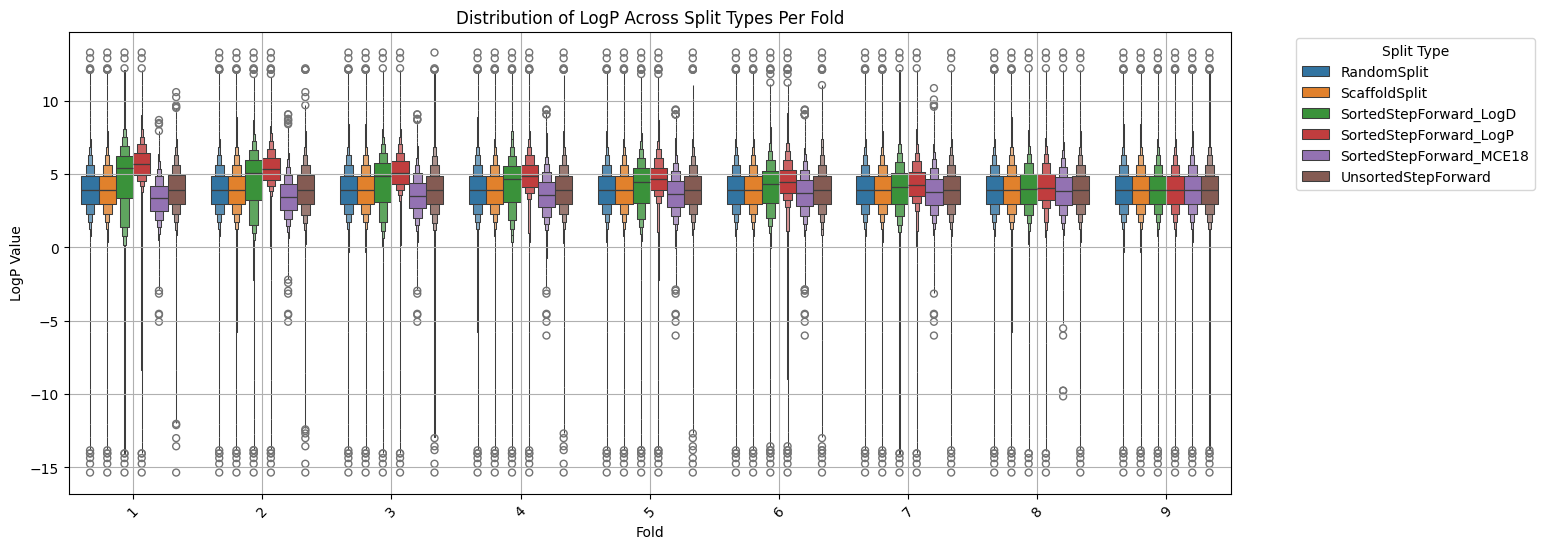

In [ ]:
for metric in metrics:
    plt.figure(figsize=(15, 6))
    sns.boxenplot(data=plot_df[plot_df["Metric"] == metric], x="Fold", y="Value", hue="Split Type")
    plt.title(f"Distribution of {metric} Across Split Types Per Fold")
    plt.xlabel("Fold")
    plt.ylabel(f"{metric} Value")
    plt.legend(title="Split Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=plot_df[plot_df["Metric"] == metric], x="Fold", y="Value", hue="Split Type", marker="o",
                 estimator="mean")
    plt.title(f"Trend of {metric} Across Split Types Per Fold")
    plt.xlabel("Fold")
    plt.ylabel(f"{metric} Value (Mean)")
    plt.legend(title="Split Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.show()